## Backprop for 1 hidden layer + BatchNorm + tanh

Copy code from prev notebooks:

In [1]:
import torch
import torch.nn.functional as F

In [2]:
with open('unique_english_words.txt', 'r') as f:
    words = [word.rstrip() for word in f.readlines()] 

SPECIAL_TOKEN = '.'
unique_symbols = sorted(list(set(list(''.join(words)))))
unique_symbols.append(SPECIAL_TOKEN)
print(f'Num of unique symbols: {len(unique_symbols)}')

stoi = {s: i for i, s in enumerate(unique_symbols)}
itos = {i: s for s, i in stoi.items()}

Num of unique symbols: 28


In [3]:
import random

random.seed(23)
random.shuffle(words)

train_split = int(0.8 * len(words))
val_split = int(0.9 * len(words))

train_words = words[:train_split]
val_words = words[train_split:val_split]
test_words = words[val_split:]

print('train:', len(train_words))
print('val:', len(val_words))
print('test:', len(test_words))

train: 758
val: 95
test: 95


In [4]:
# build dataset on full data
block_size = 3 # how many characters we are gonna use to predict the next one

def build_dataset(words):
    X = []
    y = []
    
    for word in words:
        word = SPECIAL_TOKEN * block_size + word + SPECIAL_TOKEN
        for i in range(block_size, len(word)):
            context = word[i - block_size:i]
            ch_to_predict = word[i]
    
            X.append([stoi[ch] for ch in context])
            y.append(stoi[ch_to_predict])
    
    X = torch.tensor(X)
    y = torch.tensor(y)

    return X, y


X_train, y_train = build_dataset(train_words)
X_val, y_val = build_dataset(val_words)
X_test, y_test = build_dataset(test_words)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([7182, 3]) torch.Size([7182])
torch.Size([904, 3]) torch.Size([904])
torch.Size([931, 3]) torch.Size([931])


In [5]:
g = torch.Generator().manual_seed(23)

vector_dim = 2
C = torch.randn((len(unique_symbols), vector_dim),             generator = g)

hidden_layer_size = 100
W1 = torch.randn((block_size * vector_dim, hidden_layer_size), generator = g) * (5/3.) / (block_size * vector_dim) ** 0.5
b1 = torch.randn((hidden_layer_size,),                         generator = g) * 0.1
W2 = torch.randn((hidden_layer_size, len(unique_symbols)),     generator = g) * 0.1
b2 = torch.randn((len(unique_symbols),),                       generator = g) * 0.1

## batch norm trainable params
bn_gain = torch.randn((1, hidden_layer_size)) * 0.1 + 1
bn_bias = torch.randn((1, hidden_layer_size)) * 0.1

params = [C, W1, b1, W2, b2, bn_gain, bn_bias]
for p in params:
    p.requires_grad = True

In [6]:
# forward pass (1 iteration)

batch_size = 64
rand_indecies = torch.randint(0, X_train.shape[0], (batch_size, ), generator = g)

x_batch = X_train[rand_indecies, ...]
y_batch = y_train[rand_indecies, ...]

# ---------------forward pass---------------
emb = C[x_batch] # shape: [batch_size, block_size, vector_dim]
emb_cat = emb.view(-1, block_size * vector_dim)
h_prebn =  emb_cat @ W1 + b1


## BATCH NORM
#mean
bn_mean = (1/batch_size) * h_prebn.sum(dim = 0, keepdim = True)

#variance
bn_diff = h_prebn - bn_mean
bn_diff_2 = bn_diff ** 2
bn_var = (1/(batch_size - 1)) * bn_diff_2.sum(dim = 0, keepdim = True)
bn_std_inv = (bn_var + 1e-5) ** (-0.5) # 1e-5 to avoid division by 0

bn_norm = bn_diff * bn_std_inv
bn_scaled = bn_gain * bn_norm + bn_bias

h = torch.tanh(bn_scaled)
logits = h @ W2 + b2


# -----softmax-----
# subtract max values to avoid getting exp ** big_value = inf
logit_maxes = logits.max(dim = 1, keepdim = True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum_inv = counts.sum(dim = 1, keepdim = True)  ** -1
probs = counts * counts_sum_inv

#----loss----
log_probs = probs[torch.arange(probs.shape[0]), y_batch].log()
loss = -log_probs.mean() # neg_log_likelihood
loss


#----backward pass-------
for p in params:
    p.grad = None

for p in [log_probs, probs, counts_sum_inv, counts, norm_logits, logit_maxes, logits, 
          h, bn_scaled, bn_norm, bn_std_inv, bn_var, bn_diff_2, bn_diff, bn_mean,
         h_prebn, emb_cat, emb]:
    p.retain_grad()

loss.backward()

# Breaking backprob by logical chunks

In [7]:
# function that compares grad calculated manually and grad calculated by torch

def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

## SOFTMAX

In [8]:
# logit_maxes = logits.max(dim = 1, keepdim = True).values
# norm_logits = logits - logit_maxes
# counts = norm_logits.exp()
# counts_sum_inv = counts.sum(dim = 1, keepdim = True) ** -1
# probs = counts * counts_sum_inv


# #----loss----
# log_probs = probs[torch.arange(probs.shape[0]), y_batch].log()
# loss = -log_probs.mean() # neg_log_likelihood
# loss

In [9]:
# ----------loss = -log_probs.mean()
d_loss_d_log_probs = -torch.full((batch_size, ), 1./batch_size)
cmp('logprobs', d_loss_d_log_probs, log_probs)

# ----------log_probs = probs[torch.arange(probs.shape[0]), y_batch].log()
d_log_probs_d_probs = 1 / probs # d/dx (ln(x)) = 1 / x
mask = torch.zeros(d_log_probs_d_probs.shape)
mask[torch.arange(probs.shape[0]), y_batch] = 1
d_loss_d_probs = d_loss_d_log_probs.view(batch_size, 1) * d_log_probs_d_probs * mask
cmp('probs', d_loss_d_probs, probs)

# ----------probs = counts * counts_sum_inv
d_loss_d_counts_sum_inv = (d_loss_d_probs * counts).sum(1, keepdim = True)
cmp('counts_sum_inv', d_loss_d_counts_sum_inv, counts_sum_inv)

# ----------probs = counts * counts_sum_inv
d_loss_d_counts = d_loss_d_probs * counts_sum_inv

# but 'counts' are used in counts_sum_inv = counts.sum(dim = 1, keepdim = True) ** -1 as well
# so we are not finished calculating its gradients

# ----------counts_sum_inv = counts.sum(dim = 1, keepdim = True) ** -1 
d_loss_d_counts_2 = d_loss_d_counts_sum_inv * (- counts.sum(dim = 1, keepdim = True) ** -2)# d(1/x)/dx = -1/x**2
d_loss_d_counts = d_loss_d_counts + d_loss_d_counts_2
cmp('counts', d_loss_d_counts, counts)

#----------counts = norm_logits.exp()
# d_exp/d_x = exp(x)
d_loss_d_norm_logits = d_loss_d_counts * counts # = norm_logits.exp() 
cmp('norm_logits', d_loss_d_norm_logits, norm_logits)

# ----------norm_logits = logits - logit_maxes
# 'logits' are using to calculate logit_maxes as well! So this is not a final grad! 
d_loss_d_logits = d_loss_d_norm_logits * torch.ones(logits.shape)

# logit_maxes shape is [batch_size, 1] => grad should have the same shape
d_loss_d_logit_maxes = (d_loss_d_norm_logits * -torch.ones(logit_maxes.shape)).sum(1, keepdim = True) 
cmp('logit_maxes', d_loss_d_logit_maxes, logit_maxes)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


In [10]:
# ideally d_loss_d_logit_maxes should be 0
# because this operation 'logits - logit_maxes' does not affect neither counts nor probs nor loss!
# indeed we get really small (close to 0) gradient values which demonstarte how small is the impact of logit_maxes on loss
d_loss_d_logit_maxes

tensor([[-2.0955e-09],
        [-3.4925e-10],
        [ 9.3132e-10],
        [ 0.0000e+00],
        [ 4.6566e-10],
        [-1.3970e-09],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-1.1642e-09],
        [ 0.0000e+00],
        [ 1.1642e-09],
        [ 2.3283e-10],
        [-4.6566e-10],
        [ 2.3283e-10],
        [ 0.0000e+00],
        [ 1.5134e-09],
        [-4.6566e-10],
        [ 4.6566e-10],
        [-1.8626e-09],
        [-9.3132e-10],
        [-9.3132e-10],
        [-3.4925e-09],
        [ 1.3970e-09],
        [-8.1491e-10],
        [ 1.7462e-09],
        [-4.6566e-10],
        [ 0.0000e+00],
        [ 6.9849e-10],
        [-6.9849e-10],
        [-9.3132e-10],
        [ 9.3132e-10],
        [-4.6566e-10],
        [ 9.3132e-10],
        [-2.5611e-09],
        [ 6.9849e-10],
        [-5.8208e-10],
        [ 1.3970e-09],
        [ 2.3283e-10],
        [ 9.3132e-10],
        [ 2.3283e-10],
        [ 3.7253e-09],
        [ 0.0000e+00],
        [ 1.8626e-09],
        [-4

In [11]:
# ----------logit_maxes = logits.max(dim = 1, keepdim = True).values
d_loss_d_logits_1 = torch.zeros(logits.shape)
d_loss_d_logits_1[range(d_loss_d_logits_1.shape[0]), logits.max(dim = 1).indices] = 1
d_loss_d_logits += d_loss_d_logits_1 * d_loss_d_logit_maxes
cmp('logits', d_loss_d_logits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


## Batch Norm

In [12]:
# #mean
# bn_mean = (1/batch_size) * h_prebn.sum(dim = 0, keepdim = True)

# #variance
# bn_diff = h_prebn - bn_mean
# bn_diff_2 = bn_diff ** 2
# bn_var = (1/(batch_size - 1)) * bn_diff_2.sum(dim = 0, keepdim = True)
# bn_std_inv = (bn_var + 1e-5) ** (-0.5) # 1e-5 to avoid division by 0
# bn_norm = bn_diff * bn_std_inv
# bn_scaled = bn_gain * bn_norm + bn_bias

# h = torch.tanh(bn_scaled)
# logits = h @ W2 + b2
#--------------------------------------------------------------------------

# ----------logits = h @ W2 + b2
d_loss_d_h = d_loss_d_logits @ W2.T 
cmp('h', d_loss_d_h, h)

d_loss_d_W2 = h.T @ d_loss_d_logits
cmp('W2', d_loss_d_W2, W2)

d_loss_d_b2 = 1 * d_loss_d_logits.sum(0)
cmp('b2', d_loss_d_b2, b2)

# ----------h = torch.tanh(bn_scaled)

# d_tanh = 1 - tanh**2
d_loss_d_bn_scaled = d_loss_d_h * (1 - h**2)
cmp('bn_scaled', d_loss_d_bn_scaled, bn_scaled)

# bn_scaled = bn_gain * bn_norm + bn_bias
d_loss_d_bn_gain = (bn_norm * d_loss_d_bn_scaled).sum(0, keepdim = True)
cmp('bn_gain', d_loss_d_bn_gain, bn_gain)

d_loss_d_bn_norm = bn_gain * d_loss_d_bn_scaled
cmp('bn_norm', d_loss_d_bn_norm, bn_norm)

d_loss_d_bn_bias = 1 * d_loss_d_bn_scaled.sum(0, keepdim = True)
cmp('bn_bias', d_loss_d_bn_bias, bn_bias)

# ----------bn_norm = bn_diff * bn_std_inv
d_loss_d_bn_diff = d_loss_d_bn_norm * bn_std_inv
d_loss_d_bn_std_inv = (d_loss_d_bn_norm * bn_diff).sum(0, keepdim = True)
cmp('bn_std_inv', d_loss_d_bn_std_inv, bn_std_inv)

# ----------bn_std_inv = (bn_var + 1e-5) ** (-0.5) # 1e-5 to avoid division by 0
d_loss_d_bn_var = -0.5 * (bn_var + 1e-5) ** (-1.5) * d_loss_d_bn_std_inv
cmp('bn_var', d_loss_d_bn_var, bn_var)

# ----------bn_var = (1/(batch_size - 1)) * bn_diff_2.sum(dim = 0, keepdim = True)
d_loss_d_bn_diff_2 = torch.full(bn_diff_2.shape, 1./(batch_size - 1)) * d_loss_d_bn_var
cmp('bn_diff_2', d_loss_d_bn_diff_2, bn_diff_2)

# ----------bn_diff_2 = bn_diff ** 2
d_loss_d_bn_diff += 2 * bn_diff * d_loss_d_bn_diff_2
cmp('bn_diff', d_loss_d_bn_diff, bn_diff)

# ----------bn_diff = h_prebn - bn_mean
d_loss_d_h_prebn = 1 * d_loss_d_bn_diff.clone()

d_loss_d_bn_mean = (-1 * d_loss_d_bn_diff).sum(0, keepdim = True)
cmp('bn_mean', d_loss_d_bn_mean, bn_mean)

# ----------bn_mean = (1/batch_size) * h_prebn.sum(dim = 0, keepdim = True)
d_loss_d_h_prebn += d_loss_d_bn_mean *  torch.full(h_prebn.shape, 1./(batch_size))
cmp('h_prebn', d_loss_d_h_prebn, h_prebn)

h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
bn_scaled       | exact: True  | approximate: True  | maxdiff: 0.0
bn_gain         | exact: True  | approximate: True  | maxdiff: 0.0
bn_norm         | exact: True  | approximate: True  | maxdiff: 0.0
bn_bias         | exact: True  | approximate: True  | maxdiff: 0.0
bn_std_inv      | exact: True  | approximate: True  | maxdiff: 0.0
bn_var          | exact: True  | approximate: True  | maxdiff: 0.0
bn_diff_2       | exact: True  | approximate: True  | maxdiff: 0.0
bn_diff         | exact: True  | approximate: True  | maxdiff: 0.0
bn_mean         | exact: True  | approximate: True  | maxdiff: 0.0
h_prebn         | exact: True  | approximate: True  | maxdiff: 0.0


In [13]:
emb_cat.shape, d_loss_d_h_prebn.shape, W1.shape, b1.shape

(torch.Size([64, 6]),
 torch.Size([64, 100]),
 torch.Size([6, 100]),
 torch.Size([100]))

## first linear layer

In [14]:
# emb = C[x_batch] # shape: [batch_size, block_size, vector_dim]
# emb_cat = emb.view(-1, block_size * vector_dim)
# h_prebn =  emb_cat @ W1 + b1
#------------------------------------------------------------------

# ----------h_prebn =  emb_cat @ W1 + b1
d_loss_d_emb_cat = d_loss_d_h_prebn @ W1.T
cmp('emb_cat', d_loss_d_emb_cat, emb_cat)

d_loss_d_W1 = emb_cat.T @ d_loss_d_h_prebn
cmp('W1', d_loss_d_W1, W1)

d_loss_d_b1 = d_loss_d_h_prebn.sum(0)
cmp('b1', d_loss_d_b1, b1)


# ----------emb_cat = emb.view(-1, block_size * vector_dim)
d_loss_d_emb = d_loss_d_emb_cat.view(emb.shape)
cmp('emb', d_loss_d_emb, emb)

emb_cat         | exact: True  | approximate: True  | maxdiff: 0.0
W1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0
emb             | exact: True  | approximate: True  | maxdiff: 0.0


In [15]:
d_loss_d_C = torch.zeros(C.shape)
for block_i in range(x_batch.shape[0]):
    for i, word_j in enumerate(x_batch[block_i,...]):
        d_loss_d_C[word_j ,...] += d_loss_d_emb[block_i, i, ...]

cmp('C', d_loss_d_C, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


# Putting it all together

In [33]:
g = torch.Generator().manual_seed(23)

vector_dim = 2
C = torch.randn((len(unique_symbols), vector_dim),             generator = g)

hidden_layer_size = 100
W1 = torch.randn((block_size * vector_dim, hidden_layer_size), generator = g) * (5/3.) / (block_size * vector_dim) ** 0.5
b1 = torch.randn((hidden_layer_size,),                         generator = g) * 0.1
W2 = torch.randn((hidden_layer_size, len(unique_symbols)),     generator = g) * 0.1
b2 = torch.randn((len(unique_symbols),),                       generator = g) * 0.1

## batch norm trainable params
bn_gain = torch.randn((1, hidden_layer_size)) * 0.1 + 1
bn_bias = torch.randn((1, hidden_layer_size)) * 0.1

# do not need this
# params = [C, W1, b1, W2, b2, bn_gain, bn_bias]
# for p in params:
#     p.requires_grad = True

In [34]:
n_iter = 50_000
losses_train = []
losses_val = []

batch_size = 64

with torch.no_grad():
    for i_iter in range(n_iter):
        rand_indecies = torch.randint(0, X_train.shape[0], (batch_size, ), generator = g)
    
        x_batch = X_train[rand_indecies, ...]
        y_batch = y_train[rand_indecies, ...]
    
        # ---------------forward pass---------------
    
        emb = C[x_batch] # shape: [batch_size, block_size, vector_dim]
        emb_cat = emb.view(-1, block_size * vector_dim)
        h_prebn =  emb_cat @ W1 + b1
        
        ## BATCH NORM
        #mean
        bn_mean = (1/batch_size) * h_prebn.sum(dim = 0, keepdim = True)
        
        #variance
        bn_diff = h_prebn - bn_mean
        bn_diff_2 = bn_diff ** 2
        bn_var = (1/(batch_size - 1)) * bn_diff_2.sum(dim = 0, keepdim = True)
        bn_std_inv = (bn_var + 1e-5) ** (-0.5) # 1e-5 to avoid division by 0
        
        bn_norm = bn_diff * bn_std_inv
        bn_scaled = bn_gain * bn_norm + bn_bias
        
        h = torch.tanh(bn_scaled)
        logits = h @ W2 + b2
        
        # -----softmax-----
        # subtract max values to avoid getting exp ** big_value = inf
        logit_maxes = logits.max(dim = 1, keepdim = True).values
        norm_logits = logits - logit_maxes
        counts = norm_logits.exp()
        counts_sum_inv = counts.sum(dim = 1, keepdim = True)  ** -1
        probs = counts * counts_sum_inv
        
        #----loss----
        log_probs = probs[torch.arange(probs.shape[0]), y_batch].log()
        loss = -log_probs.mean() # neg_log_likelihood
        losses_train.append(loss.item())
        
        # ---------------backward pass---------------
        # for p in params:
        #     p.grad = None
        # loss.backward()
        
        d_loss_d_log_probs = -torch.full((batch_size, ), 1./batch_size)
        
        d_log_probs_d_probs = 1 / probs
        mask = torch.zeros(d_log_probs_d_probs.shape)
        mask[torch.arange(probs.shape[0]), y_batch] = 1
        d_loss_d_probs = d_loss_d_log_probs.view(batch_size, 1) * d_log_probs_d_probs * mask
    
        d_loss_d_counts_sum_inv = (d_loss_d_probs * counts).sum(1, keepdim = True)
        d_loss_d_counts = d_loss_d_probs * counts_sum_inv
        
        d_loss_d_counts_2 = d_loss_d_counts_sum_inv * (-counts.sum(dim = 1, keepdim = True) ** -2)
        d_loss_d_counts = d_loss_d_counts + d_loss_d_counts_2
    
        d_loss_d_norm_logits = d_loss_d_counts * counts 
        d_loss_d_logits = d_loss_d_norm_logits * torch.ones(logits.shape)
        
        d_loss_d_logit_maxes = (d_loss_d_norm_logits * -torch.ones(logit_maxes.shape)).sum(1, keepdim = True) 
    
        d_loss_d_logits_1 = torch.zeros(logits.shape)
        d_loss_d_logits_1[range(d_loss_d_logits_1.shape[0]), logits.max(dim = 1).indices] = 1
        d_loss_d_logits += d_loss_d_logits_1 * d_loss_d_logit_maxes
    
        d_loss_d_h = d_loss_d_logits @ W2.T 
        d_loss_d_W2 = h.T @ d_loss_d_logits
        d_loss_d_b2 = 1 * d_loss_d_logits.sum(0)
        d_loss_d_bn_scaled = d_loss_d_h * (1 - h**2)
        d_loss_d_bn_gain = (bn_norm * d_loss_d_bn_scaled).sum(0, keepdim = True)
        d_loss_d_bn_norm = bn_gain * d_loss_d_bn_scaled
        d_loss_d_bn_bias = 1 * d_loss_d_bn_scaled.sum(0, keepdim = True)
        d_loss_d_bn_diff = d_loss_d_bn_norm * bn_std_inv
        d_loss_d_bn_std_inv = (d_loss_d_bn_norm * bn_diff).sum(0, keepdim = True)
        d_loss_d_bn_var = -0.5 * (bn_var + 1e-5) ** (-1.5) * d_loss_d_bn_std_inv
        d_loss_d_bn_diff_2 = torch.full(bn_diff_2.shape, 1./(batch_size - 1)) * d_loss_d_bn_var
        d_loss_d_bn_diff += 2 * bn_diff * d_loss_d_bn_diff_2
        d_loss_d_h_prebn = 1 * d_loss_d_bn_diff.clone()
        d_loss_d_bn_mean = (-1 * d_loss_d_bn_diff).sum(0, keepdim = True)
        d_loss_d_h_prebn += d_loss_d_bn_mean *  torch.full(h_prebn.shape, 1./(batch_size))
    
        d_loss_d_emb_cat = d_loss_d_h_prebn @ W1.T
        d_loss_d_W1 = emb_cat.T @ d_loss_d_h_prebn
        d_loss_d_b1 = d_loss_d_h_prebn.sum(0)
        d_loss_d_emb = d_loss_d_emb_cat.view(emb.shape)
    
        d_loss_d_C = torch.zeros(C.shape)
        for block_i in range(x_batch.shape[0]):
            for i, word_j in enumerate(x_batch[block_i,...]):
                d_loss_d_C[word_j ,...] += d_loss_d_emb[block_i, i, ...]
    
        grads = [d_loss_d_C, d_loss_d_W1, d_loss_d_b1, d_loss_d_W2, d_loss_d_b2, d_loss_d_bn_gain, d_loss_d_bn_bias]
        # ---------------update---------------
        lr = 0.1 if i < 30_000 else 0.01
    
        # for p in params:
        #     p.data += -lr * p.grad
            
        # list of parameters that should be updated:
        # [C, W1, b1, W2, b2, bn_gain, bn_bias]
    
        C += -lr * d_loss_d_C
        W1 += -lr * d_loss_d_W1
        b1 += -lr * d_loss_d_b1
        W2 += -lr * d_loss_d_W2
        b2 += -lr * d_loss_d_b2
        bn_gain += -lr * d_loss_d_bn_gain
        bn_bias += -lr * d_loss_d_bn_bias
    
        if i_iter % 10_000 == 0:
            print(f'{i_iter}/{n_iter}: {loss:.4f}')

0/50000: 3.3607
10000/50000: 2.4744
20000/50000: 2.3721
30000/50000: 2.3402
40000/50000: 2.2421


In [35]:
# # useful for checking your gradients
# for p,g in zip(params, grads):
#   cmp(str(tuple(p.shape)), g, p)

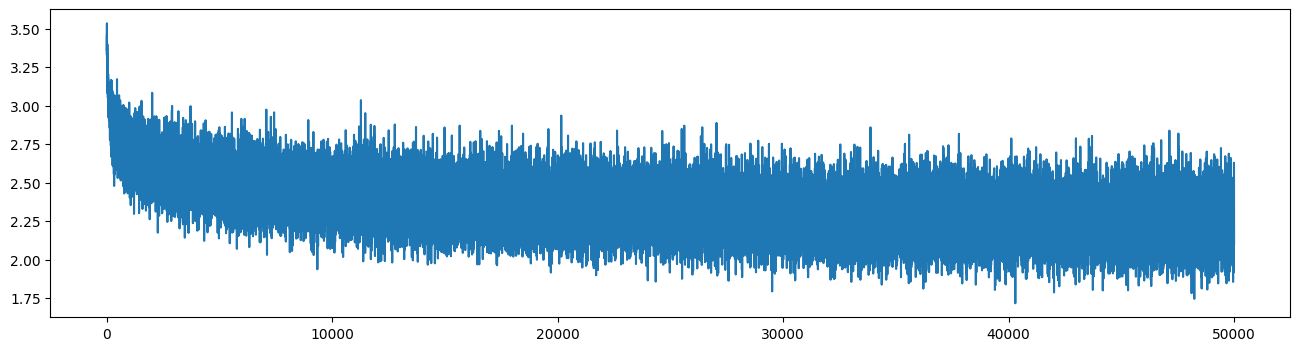

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
plt.plot(range(n_iter), losses_train)

In [37]:
# calibrate the batch norm in the end of training
# (now we cannot evaluate or get prediction for a single example 
# because NN expects getting a batch to calculate its mean and std)

with torch.no_grad():
    emb = C[X_train]
    h_preact = emb.view(-1, block_size * vector_dim) @ W1 + b1

    # measure mean and std of the whole X_train dataset
    h_preact_mean = h_preact.mean(dim = 0, keepdim = True)
    h_preact_std = h_preact.std(dim = 0, keepdim = True)

In [38]:
@torch.no_grad()
def eval(split):
    x, y = {'train' : [X_train, y_train], 
            'val' : [X_val, y_val], 
            'test' : [X_test, y_test]}[split]
    
    emb = C[x]
    h_preact = emb.view(-1, block_size * vector_dim) @ W1 + b1
    h_preact_norm = (h_preact - h_preact_mean) / h_preact_std
    h_scaled = bn_gain * h_preact_norm + bn_bias
    h = torch.tanh(h_scaled)
    
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss

In [39]:
eval('train')

tensor(2.1772)

In [40]:
eval('val')

tensor(2.4814)

## Generation of new eng words

In [41]:
g = torch.Generator().manual_seed(23)

# let's generate some new unique English words!
for i in range(20):
    word = list(SPECIAL_TOKEN * block_size)
    while True:
        context = word[-block_size:]
        context_idx = torch.tensor([stoi[ch] for ch in context])
        
        emb = C[context_idx.view(1, -1)]

        h_preact = emb.view(-1, block_size * vector_dim) @ W1 + b1
        h_preact_norm = (h_preact - h_preact_mean) / h_preact_std
        h_scaled = bn_gain * h_preact_norm + bn_bias
        h = torch.tanh(h_scaled)
        
        logits = h @ W2 + b2

        # apply softmax
        counts = logits.exp()
        probs = counts / counts.sum(dim = 1, keepdim = True)

        idx = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item()
        if idx == stoi[SPECIAL_TOKEN]: # if we meet special token - it is the end of the word!
            break  
        word.append(itos[idx])

    print(''.join(word))

...ting
...buzerrive
...sur-inoldaceritalnoral
...vony
...hogoncenity
...sorictel
...courony
...paln
...dicpe
...dachel
...conpetilimpy
...mima
...oplpherind
...abat
...mlon
...yopolunten
...purnsil
...euchmisthmicateter
...cous
...ugbaise
